In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [26]:
df = pd.read_csv('files/all.csv', index_col='Unnamed: 0')

/Users/inejj/PycharmProjects/Projectjes/appartementen/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (29,37,58,92,116,120,136,139,140,141,144,146,150,152,154,162,169,170,172,173,174,175,177,180,181,182,183,184,186,187,188,189,190,191,193,194,195,196,197,198,200,201,203,205,206,207,209,210,211,212,213) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
# Dropping street and housenumber for now, but might be intereting later use it, eg via a graph library

df = df.drop(['property.location.box', 'property.location.street',
              'property.location.latitude', 'property.location.longitude',
              'property.location.locality', 'property.location.number',
              'Address',], axis=1)

df = df.drop(columns=['flags.main','customerLogoUrl','customerName','media.pictures',
                      'flags.secondary','Price','property.title','publication.size',
                      'publication.visualisationOption','External reference',
                      'Reference number of the EPC report','Website', 'Available as of'], axis =1)

In [28]:
# Removing outliers
df = df[df['Floor :'] < 30]

# Geen openbare verkopen waar we moeten bieden of verkopen op lijfrente.
df = df[df['price.label'] == 'Price']

# Geen slaapkamers vermeld is nogal raar.

df = df[df['property.bedroomCount'] > 0]

binary_cols = ['Double glazing','Armored door','Elevator','Basement',
             'Intercom','Planning permission obtained', 'Type of building']
df[binary_cols] =df[binary_cols].replace('Yes', 1).replace('No',0)


# Striping things like 'm²square meters' from numerical columns and
# converting them to float

numerical_cols = ['CO² emission', 'Living area','Living room surface',
            'Bedroom 1 surface','Bedroom 2 surface','Cadastral income',
            'E-level (primary energy consumption)','Terrace surface']

strippers = ['kg CO2/m²','kWh/m²kilowatt hour per square meters',
            'm²square meters','€']

for x in numerical_cols:
    for y in strippers:
        df[x] = df[x].str.strip(y).replace('Not specified',np.nan)
    df[x] = df[x].str.replace('.','').str.replace(',','.').replace('', np.nan)
    df[x] = df[x].astype(float)

# Dropping columns with duplicate information
to_drop = ['Floor','price.shortDisplayPrice','price.accessibilityPrice',
           'price.mainDisplayPrice', 'property.location.floor','Bedrooms','bedrooms','bedroom',
           'transaction.sale.price','bathroom']

df = df.drop(to_drop, axis=1)

In [29]:
for column in df.columns:
    if df[column].isnull().sum() > 0.8*len(df):
        df = df.drop(column, axis=1)
    elif len(df[column].unique()) == 1:
        df = df.drop(column, axis=1)

In [30]:
nominal_cols = ['property.subtype', 'Flood zone type', 'Heating type','Kitchen type',
            'Building condition', 'Type of building','As built plan','property.location.postalCode'
            ]

df = pd.get_dummies(data= df, columns=nominal_cols)

In [31]:
# Ordinal encoding
ordinal_cols= ['Energy class']
scale_mapper = {'A':1,
                'B':2,
                'C':3,
                'D':4,
                'E':5,
                'F':6,
                'Not specified': np.nan
                }

df[ordinal_cols] = df[ordinal_cols].replace(scale_mapper)


In [32]:
# def remove_outlier(df, col):
#   q1 = df[col].quantile(0.25)
#   q3 = df[col].quantile(0.75)
#   iqr = q3 - q1
#   lower_bound  = q1 - (1.5  * iqr)
#   upper_bound = q3 + (1.5 * iqr)
#   out_df = df.loc[(df[col] > lower_bound) & (df[col] < upper_bound)]
#   return out_df
# df = remove_outlier(df,"price.mainValue")
#
# threshold = len(df) * .75
# df.dropna(thresh = threshold, axis = 1, inplace = True)
#

In [33]:
# Making a dict of all cols with missing values
missing = {col: df[col].isnull().sum() for col in df.columns if df[col].isnull().sum()  != 0}
missing

{'property.netHabitableSurface': 137,
 'Armored door': 1396,
 'Bathrooms': 217,
 'Construction year': 710,
 'Double glazing': 633,
 'E-level (primary energy consumption)': 607,
 'Energy class': 699,
 'Facades': 774,
 'Living area': 157,
 'Living room surface': 1197,
 'Planning permission obtained': 809,
 'Toilets': 542,
 'm²square meterslivable space': 137,
 'Cadastral income': 1206,
 'Bedroom 1 surface': 1173,
 'Bedroom 2 surface': 1351,
 'Covered parking spaces': 1546,
 'Intercom': 1342,
 'Terrace surface': 996,
 'Basement': 1516,
 'Number of floors': 867,
 'Elevator': 911}

In [34]:
from sklearn.impute import  MissingIndicator
missing_bin = [x for x in missing.keys() if x in binary_cols]
imp = MissingIndicator()
df[missing_bin]= imp.fit_transform(df[missing_bin])

from sklearn.impute import SimpleImputer
missing_ord= [x for x in missing.keys() if x in ordinal_cols]
imp = SimpleImputer(strategy='median')
df[missing_ord]= imp.fit_transform(df[missing_ord])

missing_num = [x for x in missing.keys() if df[x].isnull().sum() != 0]

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
df[missing_num] = imputer.fit_transform(df[missing_num])



In [35]:
from sklearn.model_selection import train_test_split
features =  list(df.drop(columns=['price.mainValue','id'],axis=1))
X = df[features]
y = df['price.mainValue']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [37]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
dummy_median = DummyRegressor(strategy='mean')
dummy_regressor = dummy_median.fit(X_train,y_train)
dummy_predicts = dummy_regressor.predict(X_test)
print("Model Accuracy:", dummy_regressor.score(X_test,y_test)*100)
print('$',mean_absolute_error(y_test,dummy_predicts))

Model Accuracy: -0.594864354995539
$ 129701.84278189455


In [38]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
models = [
          DecisionTreeRegressor(criterion='mse',max_depth=11,random_state=100),
          GradientBoostingRegressor(n_estimators=200,max_depth=12, verbose=2),
            RandomForestRegressor(min_samples_leaf =1, n_estimators=100,criterion='mse',max_depth=20,random_state=100,verbose=2)]
learning_mods = pd.DataFrame()
temp = {}

DecisionTreeRegressor(max_depth=11, random_state=100)
score on training 0.9785767302263569
r2 score 0.7315195704251398 

GradientBoostingRegressor(max_depth=12, n_estimators=200, verbose=2)
      Iter       Train Loss   Remaining Time 
         1 55705938246.9341            3.76s
         2 45320428137.0770            3.75s
         3 36896771933.3001            3.73s
         4 30070346344.0928            3.85s
         5 24516069017.6569            3.84s
         6 19975893343.3262            3.81s
         7 16295505212.9300            4.09s
         8 13287418864.9660            4.35s
         9 10842784776.3182            4.45s
        10  8862580359.2282            4.53s
        11  7251159441.9489            4.62s
        12  5943242053.0631            4.58s
        13  4873950238.4158            4.50s
        14  4007462039.0014            4.41s
        15  3299105409.2353            4.40s
        16  2721297033.3840            4.44s
        17  2242619841.0062            4.40s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


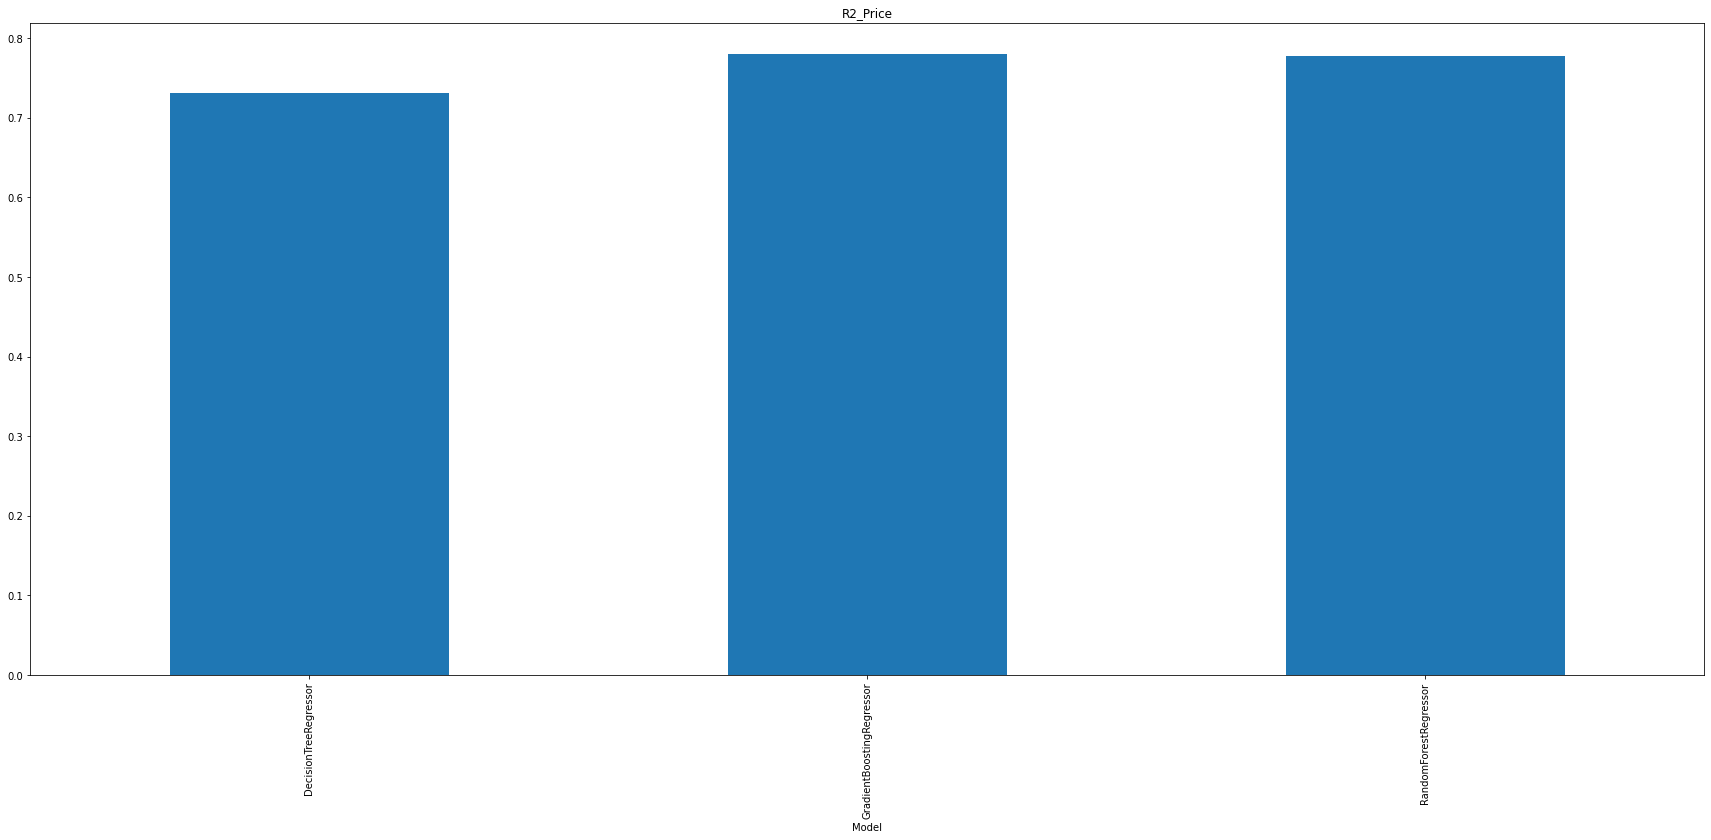

In [39]:
#run through models
for model in models:
    print(model)
    m = str(model)
    temp['Model'] = m[:m.index('(')]
    model.fit(X_train, y_train)
    temp['R2_Price'] = r2_score(y_test, model.predict(X_test))
    print('score on training',model.score(X_train, y_train))
    print('r2 score',r2_score(y_test, model.predict(X_test)),'\n')
    learning_mods = learning_mods.append([temp])
learning_mods.set_index('Model', inplace=True)

fig, axes = plt.subplots(ncols=1, figsize=(30, 12))
learning_mods.R2_Price.plot(ax=axes, kind='bar', title='R2_Price')
plt.show()

In [40]:
regressionTree_imp = model.feature_importances_
# plt.figure(figsize=(16,6))
# plt.yscale('log',nonposy='clip')
# plt.bar(range(len(regressionTree_imp)),regressionTree_imp,align='center')
# plt.xticks(range(len(regressionTree_imp)),features,rotation='vertical')
# plt.title('Feature Importance')
# plt.ylabel('Importance')
# plt.show()

In [41]:
data_tuples = list(zip(features,regressionTree_imp.tolist()))
features_importance = pd.DataFrame(data_tuples, columns=['Feature','Value'])

In [42]:
print(len(features_importance))
unimportant_features = features_importance[features_importance['Value'] < .001]
features_importance = features_importance[features_importance['Value'] > .001]
print(len(features_importance))

103
36


In [43]:
features_importance = features_importance.sort_values(by=['Value'], ascending=False)
pd.set_option('display.float_format', lambda x: '%.1000f' % x)
features_importance

,Feature,Value
14,m²square meterslivable space,0.343512974691015438022390071637346409261226654...
1,property.netHabitableSurface,0.307328348484664559681078799258102662861347198...
10,Living area,0.080119250345213555153378592876833863556385040...
60,property.location.postalCode_2000,0.034726997245879610842766993528130115009844303...
5,Construction year,0.026203550374481621859645841254859988112002611...
11,Living room surface,0.018057210766997545958734150417512864805757999...
4,Bathrooms,0.015004680232628469713218599679294129600748419...
20,Terrace surface,0.013038720665918188817977707572026702109724283...
15,Cadastral income,0.012988897002688877882481399694825086044147610...
2,Unnamed: 0.1,0.011619739245460685220234786640958191128447651...


In [44]:
data_tuples = list(zip(y_test,model.predict(X_test)))
features_importance = pd.DataFrame(data_tuples, columns=['Echte Waarde','Voorspelling'])
features_importance['Voorspelling'] = features_importance['Voorspelling'].astype(float)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [45]:
features_importance.astype(int)

,Echte Waarde,Voorspelling
0,149000,189024
1,150000,199890
2,379000,509292
3,165000,212689
4,279000,195849
...,...,...
402,199900,194270
403,230000,722390
404,150000,275399
405,285500,879011


In [47]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': range(1,10,3),
    'max_features': range(1,10,3),
    'min_samples_leaf': range(1,10,4),
    'min_samples_split': range(1,10,3),
    'n_estimators': range(100,1000,100)
}
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X, y)

Fitting 3 folds for each of 729 candidates, totalling 2187 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.8s


KeyboardInterrupt: 

In [ ]:

print("-grid.best_score_ {}".format(grid_search.best_score_))
print("grid.best_params_ {}".format(grid_search.best_params_))
print("grid.best_estimator_ {}".format(grid_search.best_estimator_))  